# 模型融合

In [104]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
# from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [105]:
# 计算各项评价指标的函数
def get_metric(clf, x, y_true):
    y_pred = clf.predict(x)
    y_proba = clf.predict_proba(x)

    acc = metrics.accuracy_score(y_true, y_pred)
    p = metrics.precision_score(y_true, y_pred)
    r = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc

In [106]:
# 画roc曲线的函数
def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw,
                 label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
    plt.savefig(title + '.jpg')
    plt.show()

In [107]:
# 标准化
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2018)
x_train, x_test, y_train, y_test = train_test_split(data, data_label, test_size=.3, random_state=2018)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [108]:
# 模型
lr_model = LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000)
svm_model = SVC(class_weight='balanced', gamma='auto', probability=True)
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100)
xg_model = XGBClassifier(n_estimators=100)

In [110]:
# stacking模型
sclf = StackingClassifier(classifiers=[xg_model, rf_model], use_probas=True,
                          average_probas=False,
                          meta_classifier=lr_model)

LR
SVM
DT
RF
XGBoost


/Users/wangzhengzheng/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/wangzhengzheng/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


StackingClassifier
                 Model dataset  Accuracy  Precision    Recall  F1 score  \
0                   LR   train  0.763451   0.520815  0.705036  0.599083   
1                   LR    test  0.714786   0.453125  0.646240  0.532721   
2                  SVM   train  0.853922   0.662313  0.851319  0.745016   
3                  SVM    test  0.727400   0.467391  0.598886  0.525031   
4                   DT   train  1.000000   1.000000  1.000000  1.000000   
5                   DT    test  0.678346   0.335526  0.284123  0.307692   
6                   RF   train  1.000000   1.000000  1.000000  1.000000   
7                   RF    test  0.764541   0.682540  0.119777  0.203791   
8              XGBoost   train  0.852720   0.858333  0.494005  0.627093   
9              XGBoost    test  0.779257   0.620879  0.314763  0.417745   
10  StackingClassifier   train  1.000000   1.000000  1.000000  1.000000   
11  StackingClassifier    test  0.778556   0.600939  0.356546  0.447552   

     

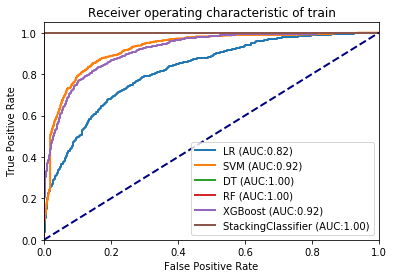

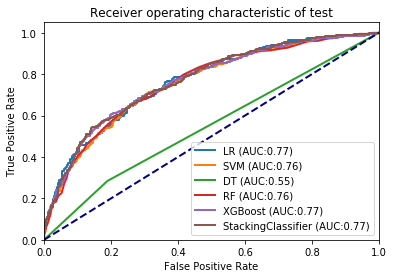

In [111]:
# 对各个模型拟合并评估
models = {'LR': lr_model,
          'SVM': svm_model,
          'DT': dt_model,
          'RF': rf_model,
          'XGBoost': xg_model,
          'StackingClassifier': sclf}

df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
row = 0
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []
for name, clf in models.items():
    clf.fit(x_train, y_train)
    print(name)
    acc, p, r, f1, fpr_train, tpr_train, auc_train = get_metric(clf, x_train, y_train)
    fprs_train.append(fpr_train)
    tprs_train.append(tpr_train)
    aucs_train.append(auc_train)
    df_result.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
    row += 1

    acc, p, r, f1, fpr_test, tpr_test, auc_test = get_metric(clf, x_test, y_test)
    fprs_test.append(fpr_test)
    tprs_test.append(tpr_test)
    aucs_test.append(auc_test)
    df_result.loc[row] = [name, 'test', acc, p, r, f1, auc_test]
    row += 1

print(df_result)
df_result.to_csv("df_result.csv")

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')